In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from keras import layers
import matplotlib.pyplot as plt
import time

In [2]:
"""import kagglehub

# Download latest version
path = kagglehub.dataset_download("phucthaiv02/butterfly-image-classification")

print("Path to dataset files:", path)"""

'import kagglehub\n\n# Download latest version\npath = kagglehub.dataset_download("phucthaiv02/butterfly-image-classification")\n\nprint("Path to dataset files:", path)'

In [3]:
train_ds = keras.utils.image_dataset_from_directory(
    r'C:\Users\pedro.quinet\Desktop\IC-UFRJ-Zanini\IC-UFRJ-Zanini\transfer_learning_reference_2\treino',
    labels="inferred",
    label_mode="int",
    class_names=None,
    color_mode="rgb",
    batch_size=32,
    shuffle=True,
    validation_split=0.1,
    subset="training",
    seed = 123)

validation_ds = keras.utils.image_dataset_from_directory(
    r'C:\Users\pedro.quinet\Desktop\IC-UFRJ-Zanini\IC-UFRJ-Zanini\transfer_learning_reference_2\treino',
    labels="inferred",
    label_mode="int",
    class_names=None,
    color_mode="rgb",
    batch_size=32,
    shuffle=True,
    validation_split=0.1,
    subset="validation",
    seed = 123)

Found 6499 files belonging to 75 classes.
Using 5850 files for training.
Found 6499 files belonging to 75 classes.
Using 649 files for validation.


In [4]:
# Em bachts de 32
print(f"Number of training samples: {train_ds.cardinality()}")
print(f"Number of validation samples: {validation_ds.cardinality()}")

Number of training samples: 183
Number of validation samples: 21


In [5]:
resize_fn = keras.layers.Resizing(150, 150)

train_ds = train_ds.map(lambda x, y: (resize_fn(x), y))
validation_ds = validation_ds.map(lambda x, y: (resize_fn(x), y))


In [6]:
augmentation_layers = [
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
]


def data_augmentation(x):
    for layer in augmentation_layers:
        x = layer(x)
    return x


train_ds = train_ds.map(lambda x, y: (data_augmentation(x), y))

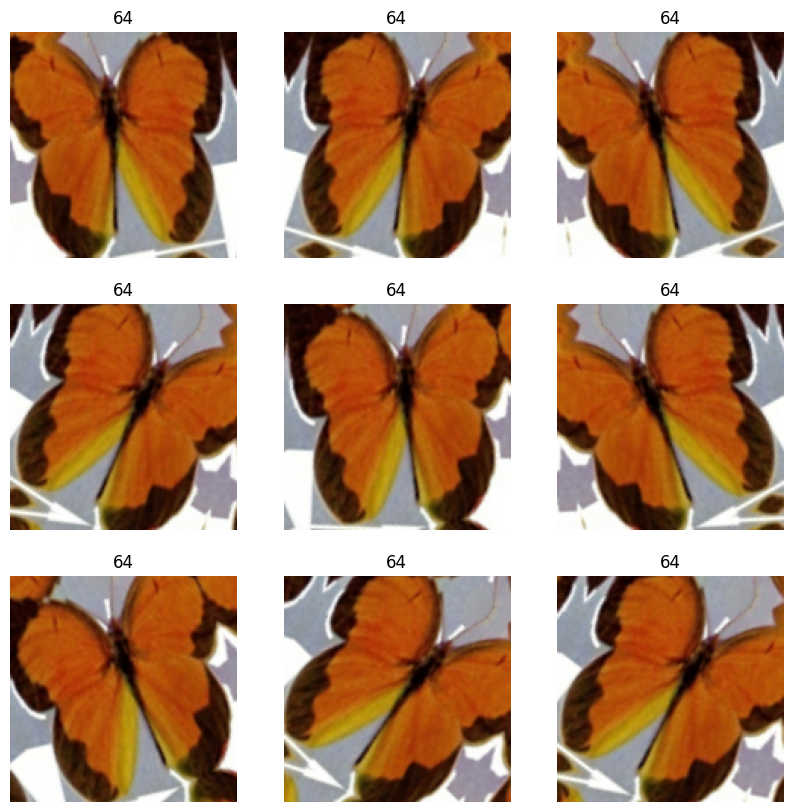

In [7]:
for images, labels in train_ds.take(1):
    plt.figure(figsize=(10, 10))
    first_image = images[0]
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        augmented_image = data_augmentation(np.expand_dims(first_image, 0))
        plt.imshow(np.array(augmented_image[0]).astype("int32"))
        plt.title(int(labels[0]))
        plt.axis("off")

In [ ]:
# Fazer o base model separado pra não demorar tanto e só juntar quando for fazer o fine-tuning.

base_model = keras.applications.Xception(
    weights="imagenet",  # Carregando os pesos do modelo pré-treinado no dataset imaginet.
    input_shape=(150, 150, 3),
    include_top=False,  # Tirar o classificador final do modelo
)

# Congelando o modelo base
base_model.trainable = False

# O input do modelo
inputs = keras.Input(shape=(150, 150, 3))

# O Xception pré treinado requer que os insputs tenham essa escala.
# de (0, 255) para (-1., +1.).
scale_layer = keras.layers.Rescaling(scale=1 / 127.5, offset=-1)
x = scale_layer(inputs)

x = base_model(x, training=False) # Passar o training = False para deixar o batchnorming layer do base_model em modo inferência.


x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dropout(0.2)(x)  # Regularizar com dropout

outputs = keras.layers.Dense(75, activation="softmax")(x) # saída com 75 classes pois temos 75 espécies de borboletas no dataset.

# Criar o modelo final
model = keras.Model(inputs, outputs)

model.compile(
    optimizer=keras.optimizers.Adam(),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"],
)


model.summary(show_trainable=True)

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━┓
┃ Layer (type)                ┃ Output Shape          ┃    Param # ┃ Trai… ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━┩
│ input_layer_1 (InputLayer)  │ (None, 150, 150, 3)   │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ rescaling (Rescaling)       │ (None, 150, 150, 3)   │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ xception (Functional)       │ (None, 5, 5, 2048)    │ 20,861,480 │   N   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ global_average_pooling2d    │ (None, 2048)          │          0 │   -   │
│ (GlobalAveragePooling2D)    │                       │            │       │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ dropout (Dropout)           │ (None, 2048)          │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ dense (Dense)               │ (None, 75)            │    153,675 │   Y   │
└─────────────────────────────┴───────────────────────┴────────────┴───────┘

 Total params: 21,015,155 (80.17 MB)

 Trainable params: 153,675 (600.29 KB)

 Non-trainable params: 20,861,480 (79.58 MB)

In [9]:
# Vamos passar as imagens pelo modelo base apra extrair as features e alimentar nosso novo modelo.

print("Extraindo features do conjunto de treino...")
features_train = base_model.predict(train_ds, batch_size=32, verbose=1)

print("Extraindo features do conjunto de validação...")
features_val = base_model.predict(validation_ds, batch_size=32, verbose=1)

print("Shape das features de treino:", features_train.shape)

Extraindo features do conjunto de treino...
183/183 ━━━━━━━━━━━━━━━━━━━━ 166s 904ms/step
Extraindo features do conjunto de validação...
21/21 ━━━━━━━━━━━━━━━━━━━━ 23s 1s/step
Shape das features de treino: (5850, 5, 5, 2048)
